# When will the German TARGET-Salden fall back to the 1 trillion euro mark?

The German TARGET-Salden have already bounced several times past the psychologically important 1 trillion euro mark (as they would say in M20), it shouldn't be long before this support breaks.

Here I would use a time series forecasting model to make an estimate. One such model is the autoregressive integrated moving average (ARIMA) model. The historical data used is the TARGET monthly average position from 2008 June to 2023 October.

**Data Source**: [External position of the Bundesbank - Assets - Other Investment - Currency and deposits - TARGET2 (net) - monthly averages based on TARGET2 business days till 2023-10](https://www.bundesbank.de/dynamic/action/en/statistics/time-series-databases/time-series-databases/745582/745582?treeAnchor=AUSSENWIRTSCHAFT&tsTab=0&tsId=BBFI1.M.N_A1.DE.4F.S121.S1.LE.A.FA.O.F221T.S._T.N.N&statisticType=BBK_ITS&dateSelect=2023)

**Random Walk Model Concept**: In a random walk model, the next value in the series is predicted to be the current value plus a random step. This step can be derived from the historical changes in the data.

## References

- [Geometric random walk model](https://people.duke.edu/~rnau/411georw.htm)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data into a pandas DataFrame from the Bundesbank csv file and skip the first 8 lines
data = pd.read_csv('TARGET2_DE_monthly_200806-202310.csv', parse_dates=True)

# Skip the first 8 lines and the last column
data = data.iloc[8:, :-1]

# Skip the first 153 lines, begin from 2020-07
# data = data.iloc[153:, :-1]

# Assign names to the columns
data.columns = ['month', 'average_position']
data['average_position'] = pd.to_numeric(data['average_position'])

# Set the "month" column as index column
data = data.set_index('month')

# Ensure the index is a DatetimeIndex
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data.index, format='%Y-%m')


data = data.sort_index()

# Print the DataFrame
print(data)

            average_position
month                       
2008-06-01         91250.626
2008-07-01        100452.660
2008-08-01        105434.623
2008-09-01        102308.935
2008-10-01         94577.183
...                      ...
2023-06-01       1065418.434
2023-07-01       1042005.552
2023-08-01       1041412.325
2023-09-01       1046653.387
2023-10-01       1045764.063

[185 rows x 1 columns]


In [7]:
# Calculate differences between consecutive observations
data['diff'] = data['average_position'].diff()

# Drop the first row with NaN difference
data = data.dropna()

print(data)

            average_position       diff
month                                  
2008-07-01        100452.660   9202.034
2008-08-01        105434.623   4981.963
2008-09-01        102308.935  -3125.688
2008-10-01         94577.183  -7731.752
2008-11-01         91503.376  -3073.807
...                      ...        ...
2023-06-01       1065418.434 -22855.131
2023-07-01       1042005.552 -23412.882
2023-08-01       1041412.325   -593.227
2023-09-01       1046653.387   5241.062
2023-10-01       1045764.063   -889.324

[184 rows x 2 columns]


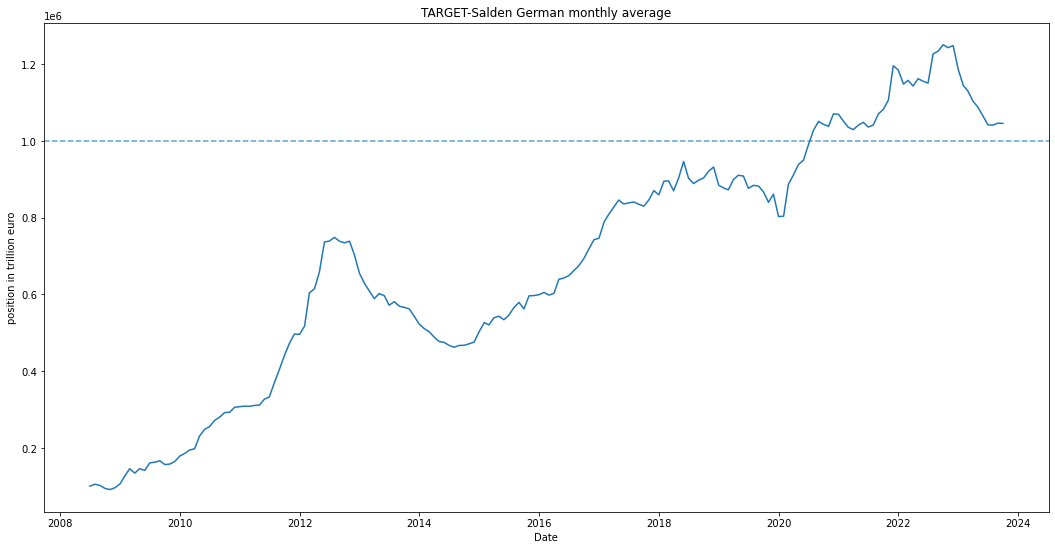

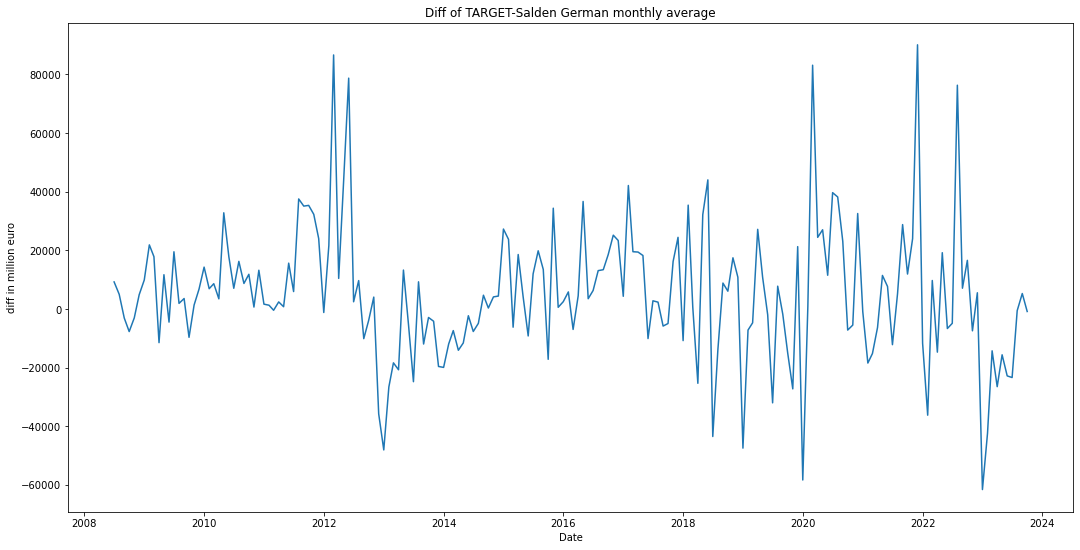

In [8]:
# Plot the time series
plt.figure(figsize=(18, 9))
plt.plot(data['average_position'])
plt.axhline(y=1e6, linestyle='--', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('position in trillion euro')
plt.title('TARGET-Salden German monthly average')
plt.show()

# Plot the ACF
plt.figure(figsize=(18, 9))
plt.plot(data['diff'])
# plt.axhline(y=1e6, linestyle='--', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('diff in million euro')
plt.title('Diff of TARGET-Salden German monthly average')
plt.show()


In [9]:
# Function to make a random walk prediction
def random_walk_forecast(last_observation, steps, differences):
    forecast = [last_observation]
    for _ in range(steps):
        step = np.random.choice(differences)
        forecast.append(forecast[-1] + step)
    return forecast


# Make predictions
last_observation = data['average_position'].iloc[-1]
steps = 18  # number of steps we try to predict
predicted_values = random_walk_forecast(last_observation, steps, data['diff'].values)

print(predicted_values)

[1045764.063, 1022351.1810000001, 1038519.5780000001, 1050176.948, 1042948.0410000001, 1007158.0130000002, 1017010.7470000002, 1009300.9260000002, 1018110.7430000001, 1027763.3280000001, 1027170.101, 1054405.213, 1058779.98, 1065668.205, 1072400.941, 1110579.26, 1078532.273, 1071303.366, 1076803.9919999999]


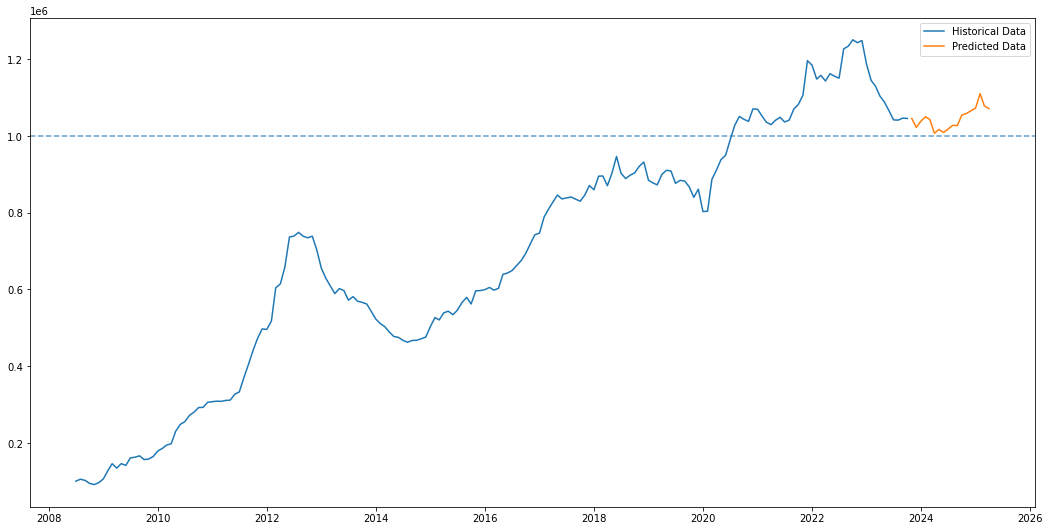

In [10]:
# Plotting settings
plt.figure(figsize=(18, 9))

# Convert DataFrame index (dates) to NumPy array
dates_np = data.index.to_numpy()

# Convert 'value' column to NumPy array
values_np = data['average_position'].to_numpy()

# Plot historical data
plt.plot(dates_np, values_np, label='Historical Data')

# Adjusting the start date for prediction_dates
# Start from the next period after the last date in historical data
next_period_start = data.index[-1] + pd.offsets.MonthEnd(1)


# Create a new index for the predicted data
# Adjust 'freq' to 'M' for monthly data
prediction_dates = pd.date_range(start = next_period_start, periods=steps, freq='M')
prediction_dates_np = prediction_dates.to_numpy()

# Ensure predicted_values is a NumPy array, 
# and ensure the lengths of predicted_values and prediction_dates match
predicted_values_np = np.array(predicted_values)[:len(prediction_dates)]


# Plot predicted data
plt.plot(prediction_dates_np, predicted_values_np, label='Predicted Data')

plt.axhline(y=1e6, linestyle='--', alpha=0.7)

plt.legend()
plt.show()